In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taco-dataset-yolo-format/README.dataset.txt
/kaggle/input/taco-dataset-yolo-format/README.roboflow.txt
/kaggle/input/taco-dataset-yolo-format/data.yaml
/kaggle/input/taco-dataset-yolo-format/valid/labels/000052_JPG_jpg.rf.37ee95937c69e8f097641e5487da719b.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000095_jpg.rf.f04834eda4bb7582b4f7a8380b8676c9.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000030_jpg.rf.8d4da2a81c714e7133277757eb4f8150.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000111_JPG_jpg.rf.909d368cb4fb2db543eadafe9ed2b80c.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000013_jpg.rf.c9273913862771c07071cc2920d1c886.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000046_jpg.rf.0e6ad76837b06f8b7a5b3392de576971.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000097_jpg.rf.0d5c094cafefd6c36f2e527289637a0c.txt
/kaggle/input/taco-dataset-yolo-format/valid/labels/000059_JPG_jpg.rf.cb0179a85ae9d550a16b5904b4735a94.tx

In [2]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 710.7 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.2/800.2 kB 6.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.55 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5771.7/8062.4 GB disk)


In [4]:
import zipfile

def create_zip(source_folder, destination_zip):
    with zipfile.ZipFile(destination_zip, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zip_ref.write(file_path, arcname=os.path.relpath(file_path, source_folder))

def extract_zip(zip_file, destination_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

source_folder = '/kaggle/input/taco-data-downsized-for-yolov8'
destination_zip = '/kaggle/working/folder.zip'
destination_folder = '/kaggle/working/'

create_zip(source_folder, destination_zip)
extract_zip(destination_zip, destination_folder)

In [5]:
%pwd

'/kaggle/working'

In [6]:
import yaml

data_yaml = dict(
    train ='/kaggle/input/taco-dataset-yolo-format/train',
    val ='/kaggle/input/taco-dataset-yolo-format/valid',
    test='/kaggle/input/taco-dataset-yolo-format/test',
    nc =18,
    names =['Aluminium foil', 'Bottle cap', 'Bottle', 'Broken glass', 'Can', 
            'Carton', 'Cigarette', 'Cup', 'Lid', 'Other litter', 'Other plastic', 
            'Paper', 'Plastic bag - wrapper', 'Plastic container', 'Pop tab', 
            'Straw', 'Styrofoam piece', 'Unlabeled litter']
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat data.yaml

{names: [Aluminium foil, Bottle cap, Bottle, Broken glass, Can, Carton, Cigarette,
    Cup, Lid, Other litter, Other plastic, Paper, Plastic bag - wrapper, Plastic container,
    Pop tab, Straw, Styrofoam piece, Unlabeled litter], nc: 18, test: /kaggle/input/taco-dataset-yolo-format/test,
  train: /kaggle/input/taco-dataset-yolo-format/train, val: /kaggle/input/taco-dataset-yolo-format/valid}


In [7]:
names =['Aluminium foil', 'Bottle cap', 'Bottle', 'Broken glass', 'Can', 
        'Carton', 'Cigarette', 'Cup', 'Lid', 'Other litter', 'Other plastic', 
        'Paper', 'Plastic bag - wrapper', 'Plastic container', 'Pop tab', 
        'Straw', 'Styrofoam piece', 'Unlabeled litter']
N=list(range(len(names)))
class_map=dict(zip(N,names))

In [8]:
model = YOLO("yolov8x.pt") 

100%|██████████| 131M/131M [00:00<00:00, 262MB/s]  


In [9]:
!yolo task=detect mode=train model=yolov8x.pt data=data.yaml epochs=4 imgsz=512

Ultralytics YOLOv8.2.55 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

In [10]:
paths2=[]
for dirname, _, filenames in os.walk('/kaggle/input/taco-dataset-yolo-format/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            paths2+=[(os.path.join(dirname, filename))]
paths2=sorted(paths2)


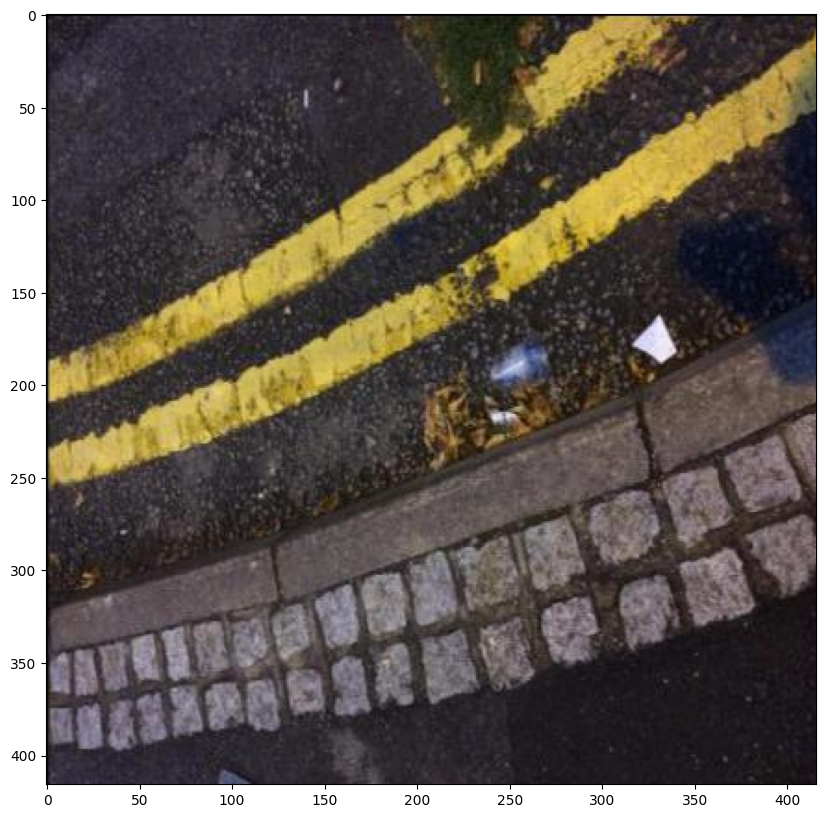

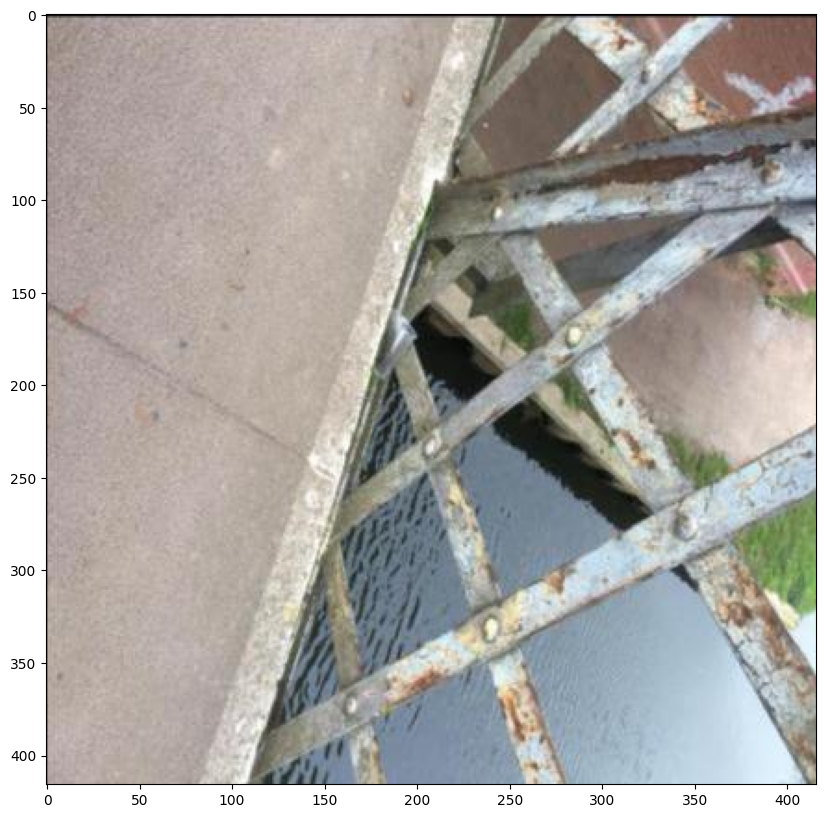

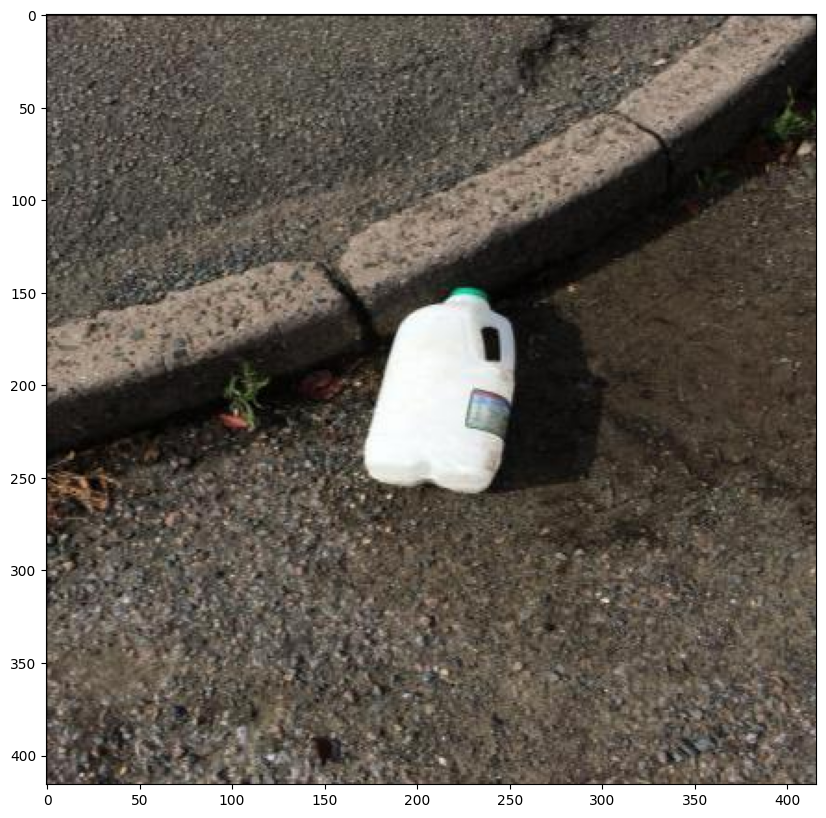

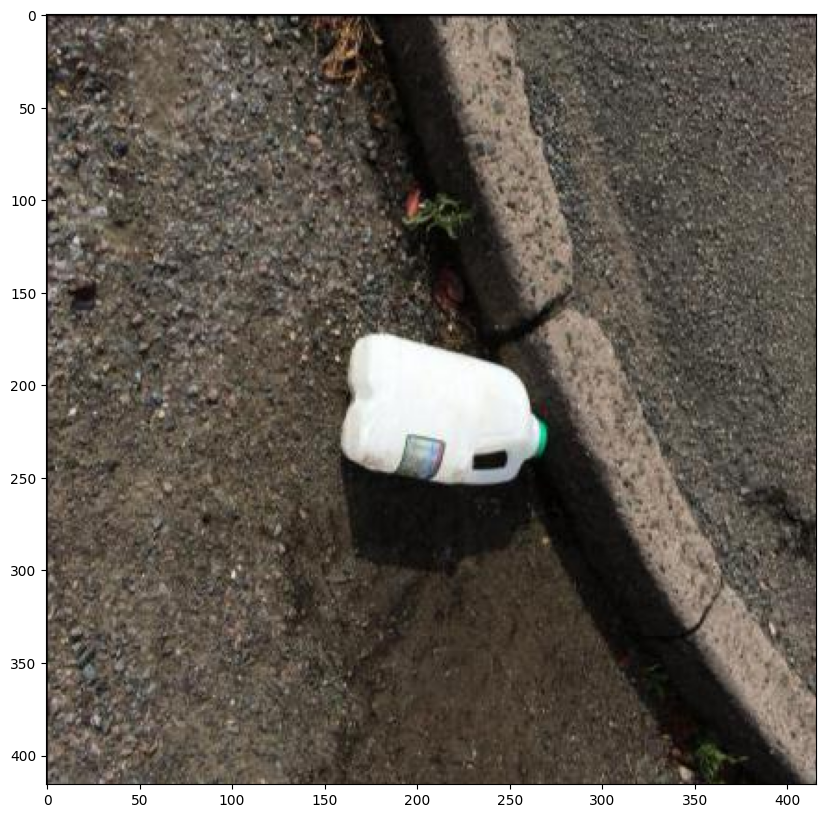

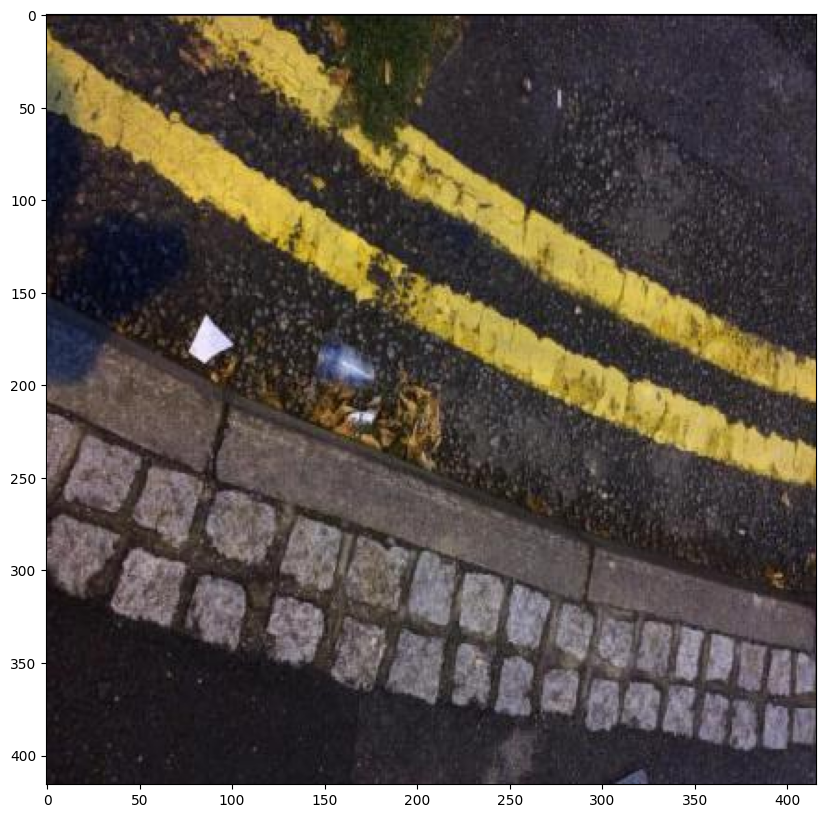

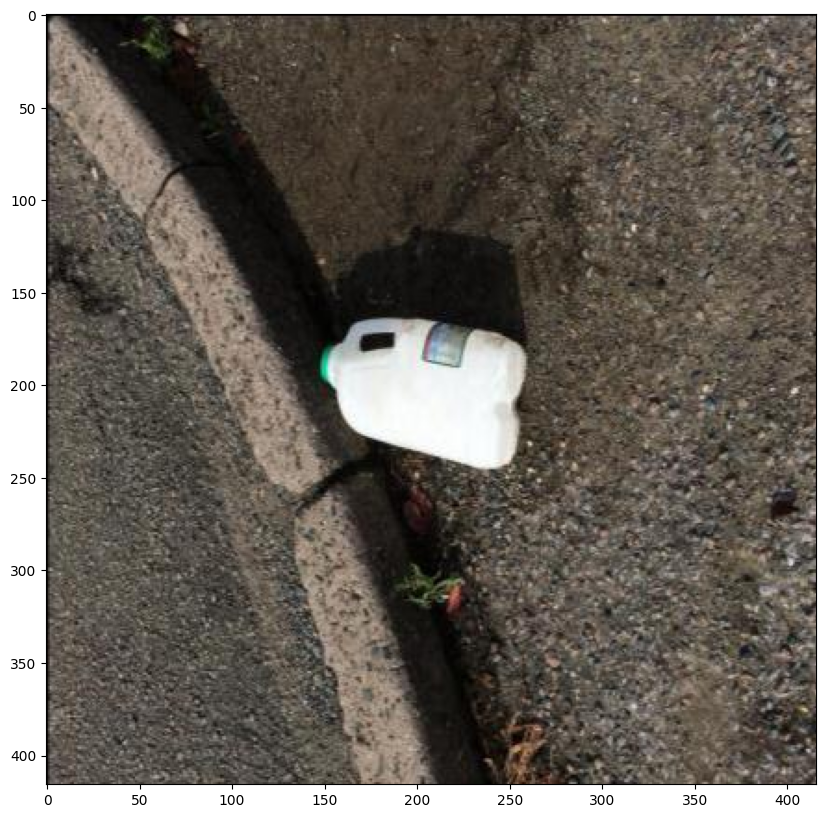

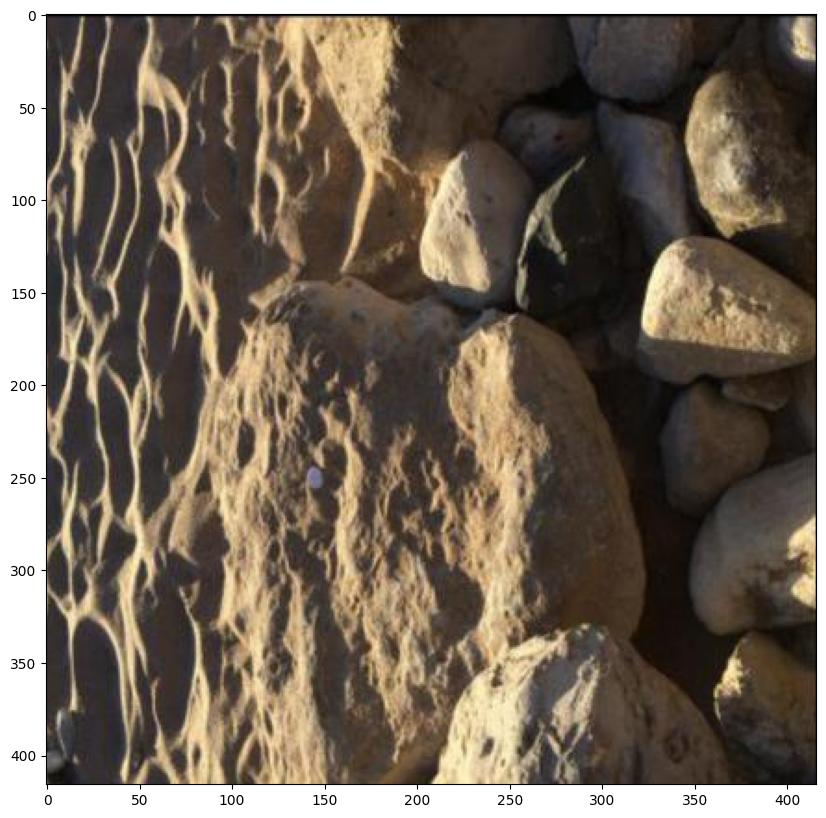

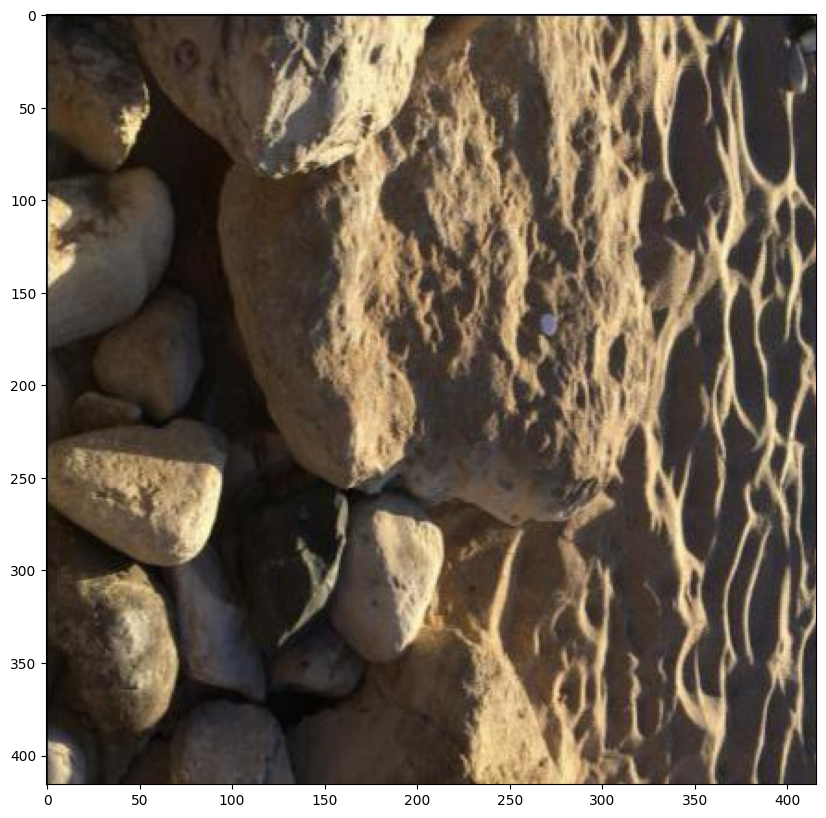

In [ ]:
for path in paths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

# Prediction

In [ ]:
best_path0='runs/detect/train/weights/best.pt'
source0='datasets/test'
# best_path1='runss/detect/train/weights/best.pt'
# source1='/kaggle/input/imgtest/img'

In [ ]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths[0])
print(len(ppaths))

In [ ]:
model2 = YOLO(best_path0,task='detect')

In [ ]:
!yolo task=detect mode=predict model={best_path0} conf=0.1 source={source0}

# Result

In [ ]:
results = model2.predict(source0,conf=0.1)
print(len(results))

In [ ]:
print((results[0].boxes.data))

In [ ]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

In [ ]:
PBOX['class']=PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX=PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

In [ ]:
def draw_box2(n0):
    
    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]
    
    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x=int(box.loc[i,'x'])
            y=int(box.loc[i,'y'])
            x2=int(box.loc[i,'x2']) 
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            cv2.putText(image, f'{label}', (x, int(y-4)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0),2)
            cv2.rectangle(image,(x,y),(x2,y2),(0,255,0),2) #green
    
    #plt.imshow(image)
    #plt.show()   
    
    return image

In [ ]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    text = plt.text(0.05, 0.05, f'Slide {0}', transform=fig.transFigure, fontsize=14, color='blue')
    plt.axis('off')
    plt.close()

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        text.set_text(f'Slide {20+i}')        
        return [im]    
    
    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000)

In [ ]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

In [ ]:
create_animation(images2)

In [ ]:
root = '/kaggle/input/imgtest/img'
fnames = os.listdir(root)